In [1]:
import os
os.chdir('/home/jovyan/work/src')
import reading
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Plot comparison stars

In [2]:
def read_lightcurves(star_ids):
    result = []
    for star in star_ids:
        df = reading.read_lightcurve_vast(f'../inputfiles/ASASSN-V_J060000.76-310027.83/vast/2019_1_bestaper/out{star:05}.dat')
        df['JDF'] = df['JD'].astype(float).to_numpy()
        df['Vrelrel'] = df['Vrel']
#        df['Vrelrel'] = df['Vrel'] - df['Vrel'].mean()
        result.append(df)
    return result

In [3]:
curves = [174, 35, 895]
dfs = read_lightcurves(curves)
print(dfs[0].info())
dfs[0].head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 9 columns):
JD         735 non-null object
Vrel       735 non-null float64
err        735 non-null float64
X          735 non-null float64
Y          735 non-null float64
unknown    735 non-null float64
file       735 non-null object
JDF        735 non-null float64
Vrelrel    735 non-null float64
dtypes: float64(7), object(2)
memory usage: 51.8+ KB
None


,JD,Vrel,err,X,Y,unknown,file,JDF,Vrelrel
0,2458836.58742,-12.620061,0.0030,813.26599,1298.03992,6.1,../data/ASASSN-V_J060000.76-310027.83/cleaned/...,2.458837e+06,-12.620061
1,2458829.82980,-12.573584,0.0038,696.96942,52.62220,6.4,../data/ASASSN-V_J060000.76-310027.83/cleaned/...,2.458830e+06,-12.573584
2,2458830.82618,-12.583819,0.0037,603.07629,186.89120,6.5,../data/ASASSN-V_J060000.76-310027.83/cleaned/...,2.458831e+06,-12.583819
3,2458830.82691,-12.569658,0.0036,602.86792,187.58569,6.1,../data/ASASSN-V_J060000.76-310027.83/cleaned/...,2.458831e+06,-12.569658
4,2458831.82153,-12.563400,0.0035,647.16559,88.56370,6.5,../data/ASASSN-V_J060000.76-310027.83/cleaned/...,2.458832e+06,-12.563400



2458849.8242 2458829.8298 -12.53128295 -12.62744061 -12.53128295

2458849.8242 2458829.8298 -10.26252835 -12.62744061 -10.26252835

2458849.8242 2458829.8298 -6.50456333 -12.62744061 -6.50456333


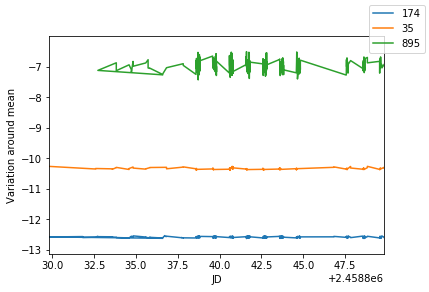

In [4]:
fig = plt.figure()

xmax, xmin, ymax, ymin =float('-inf'),float('inf'), float('-inf'),float('inf')
for frame in dfs:
    print()
    xmax = max(xmax, frame['JDF'].max())
    xmin = min(xmin, frame['JDF'].min())
    ymax = max(ymax, frame['Vrelrel'].max())
    ymin = min(ymin, frame['Vrelrel'].min())
    print(xmax, xmin, ymax, ymin, frame['Vrelrel'].max())
    plt.plot(frame['JDF'], frame['Vrelrel'])
fig.legend(curves)
plt.xlim(xmin,xmax)
plt.ylim(ymin-0.5,ymax+0.5)
plt.xlabel('JD')
plt.ylabel('Variation around mean')
plt.show()

# Plot apertures

In [5]:
# read all image.cat.info files
# get JD and aperture via regex
# plot

import glob
import re
from tqdm import tqdm
from pathlib import Path

def get_catinfo_files(vastdir):
    return [Path(f) for f in glob.glob(vastdir+'/*.cat.info')]    

def get_JD_aperture_from_catinfo(filename):
    the_regex = re.compile(r'^write_string_to_log_file\(\): JD=\s*(.*)\s*ap=\s*(\S*)\s*.*$')
    catalog_dict = {}
    with open(filename, 'r') as infile:
        for line in infile:
            thesearch = the_regex.search(line)
            if thesearch:
                return thesearch.group(1), thesearch.group(2)
    return None

vastdir = '../inputfiles/ASASSN-V_J060000.76-310027.83/vast/2019_1_bestaper'
catinfo_files = get_catinfo_files(vastdir)
x = []
y = []
for file in tqdm(catinfo_files):
    a,b = get_JD_aperture_from_catinfo(file)
    x.append(float(a))
    y.append(float(b))
    #print(f"{a}, {b}, {len(x)}, {len(y)}")




100%|██████████| 749/749 [00:03<00:00, 224.04it/s]


Text(0, 0.5, 'Aperture (px)')

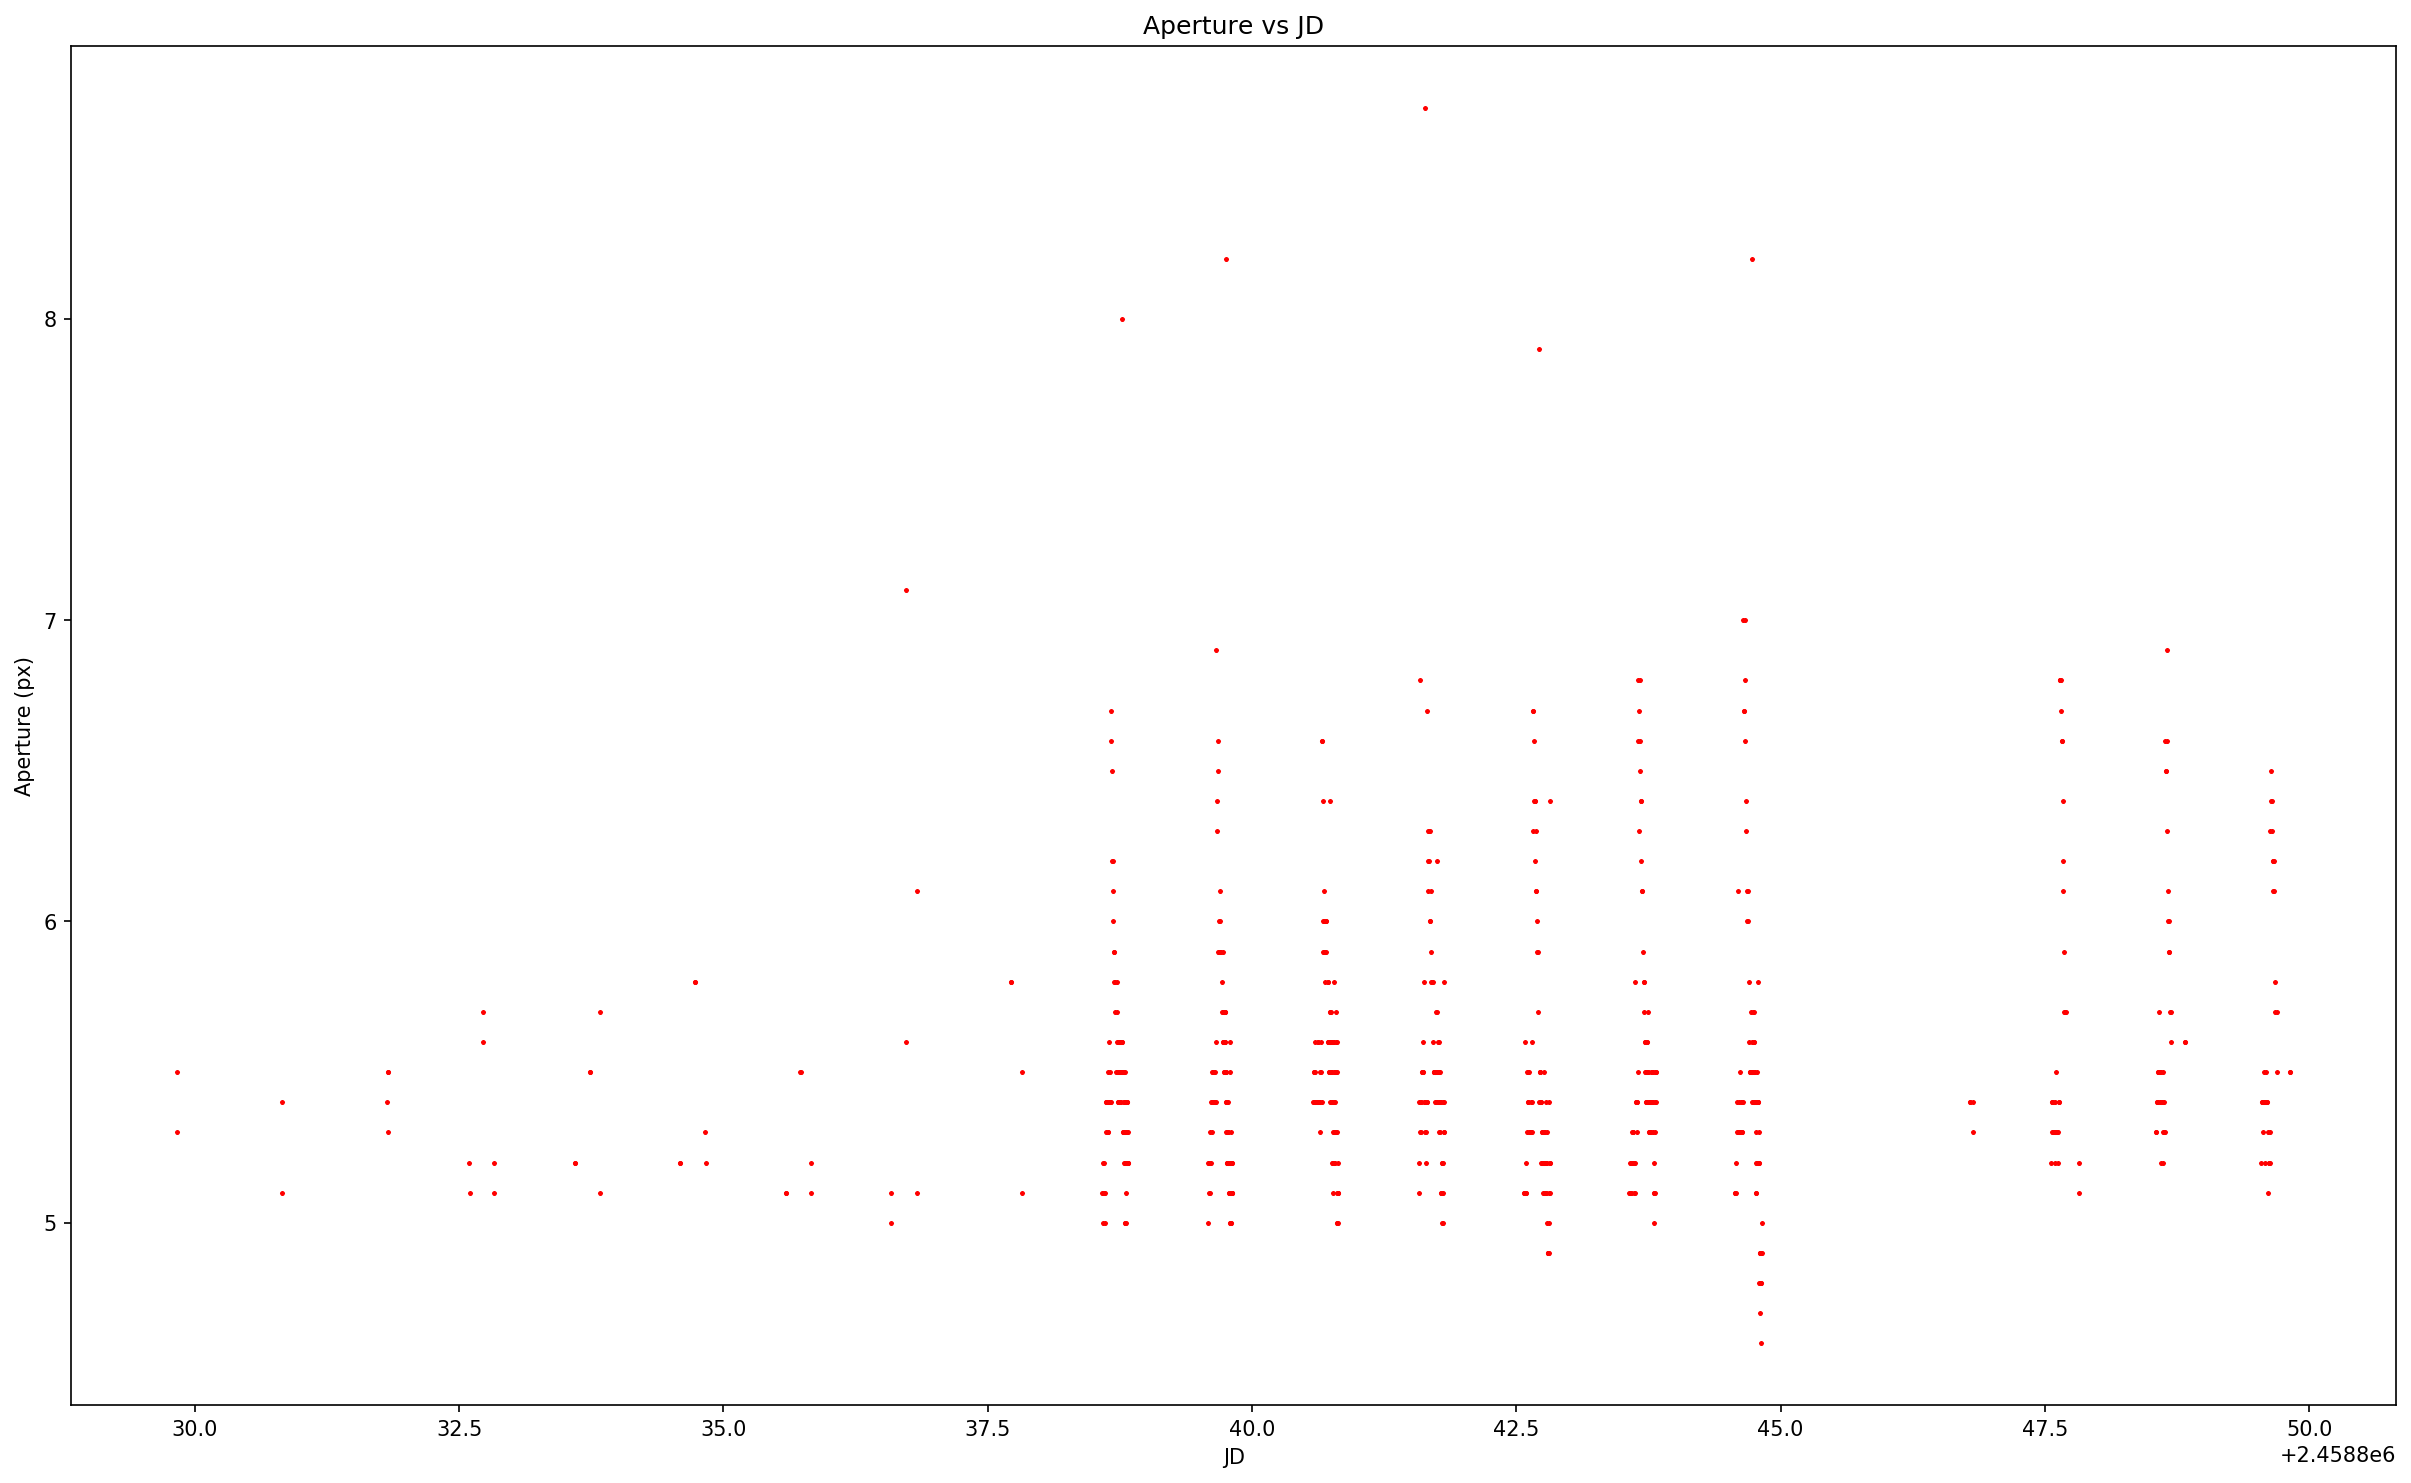

In [6]:
fig = plt.figure(figsize=(20, 12), dpi=150)
ax = plt.subplot(111)
ax.plot(x,y, '*r', markersize=2)
ax.tick_params(axis='x', which='minor', bottom=False)
ax.set_title('Aperture vs JD')
plt.xlabel('JD')
plt.ylabel('Aperture (px)')



100%|██████████| 749/749 [03:45<00:00,  3.32it/s]


Text(0, 0.5, 'Aperture (px)')

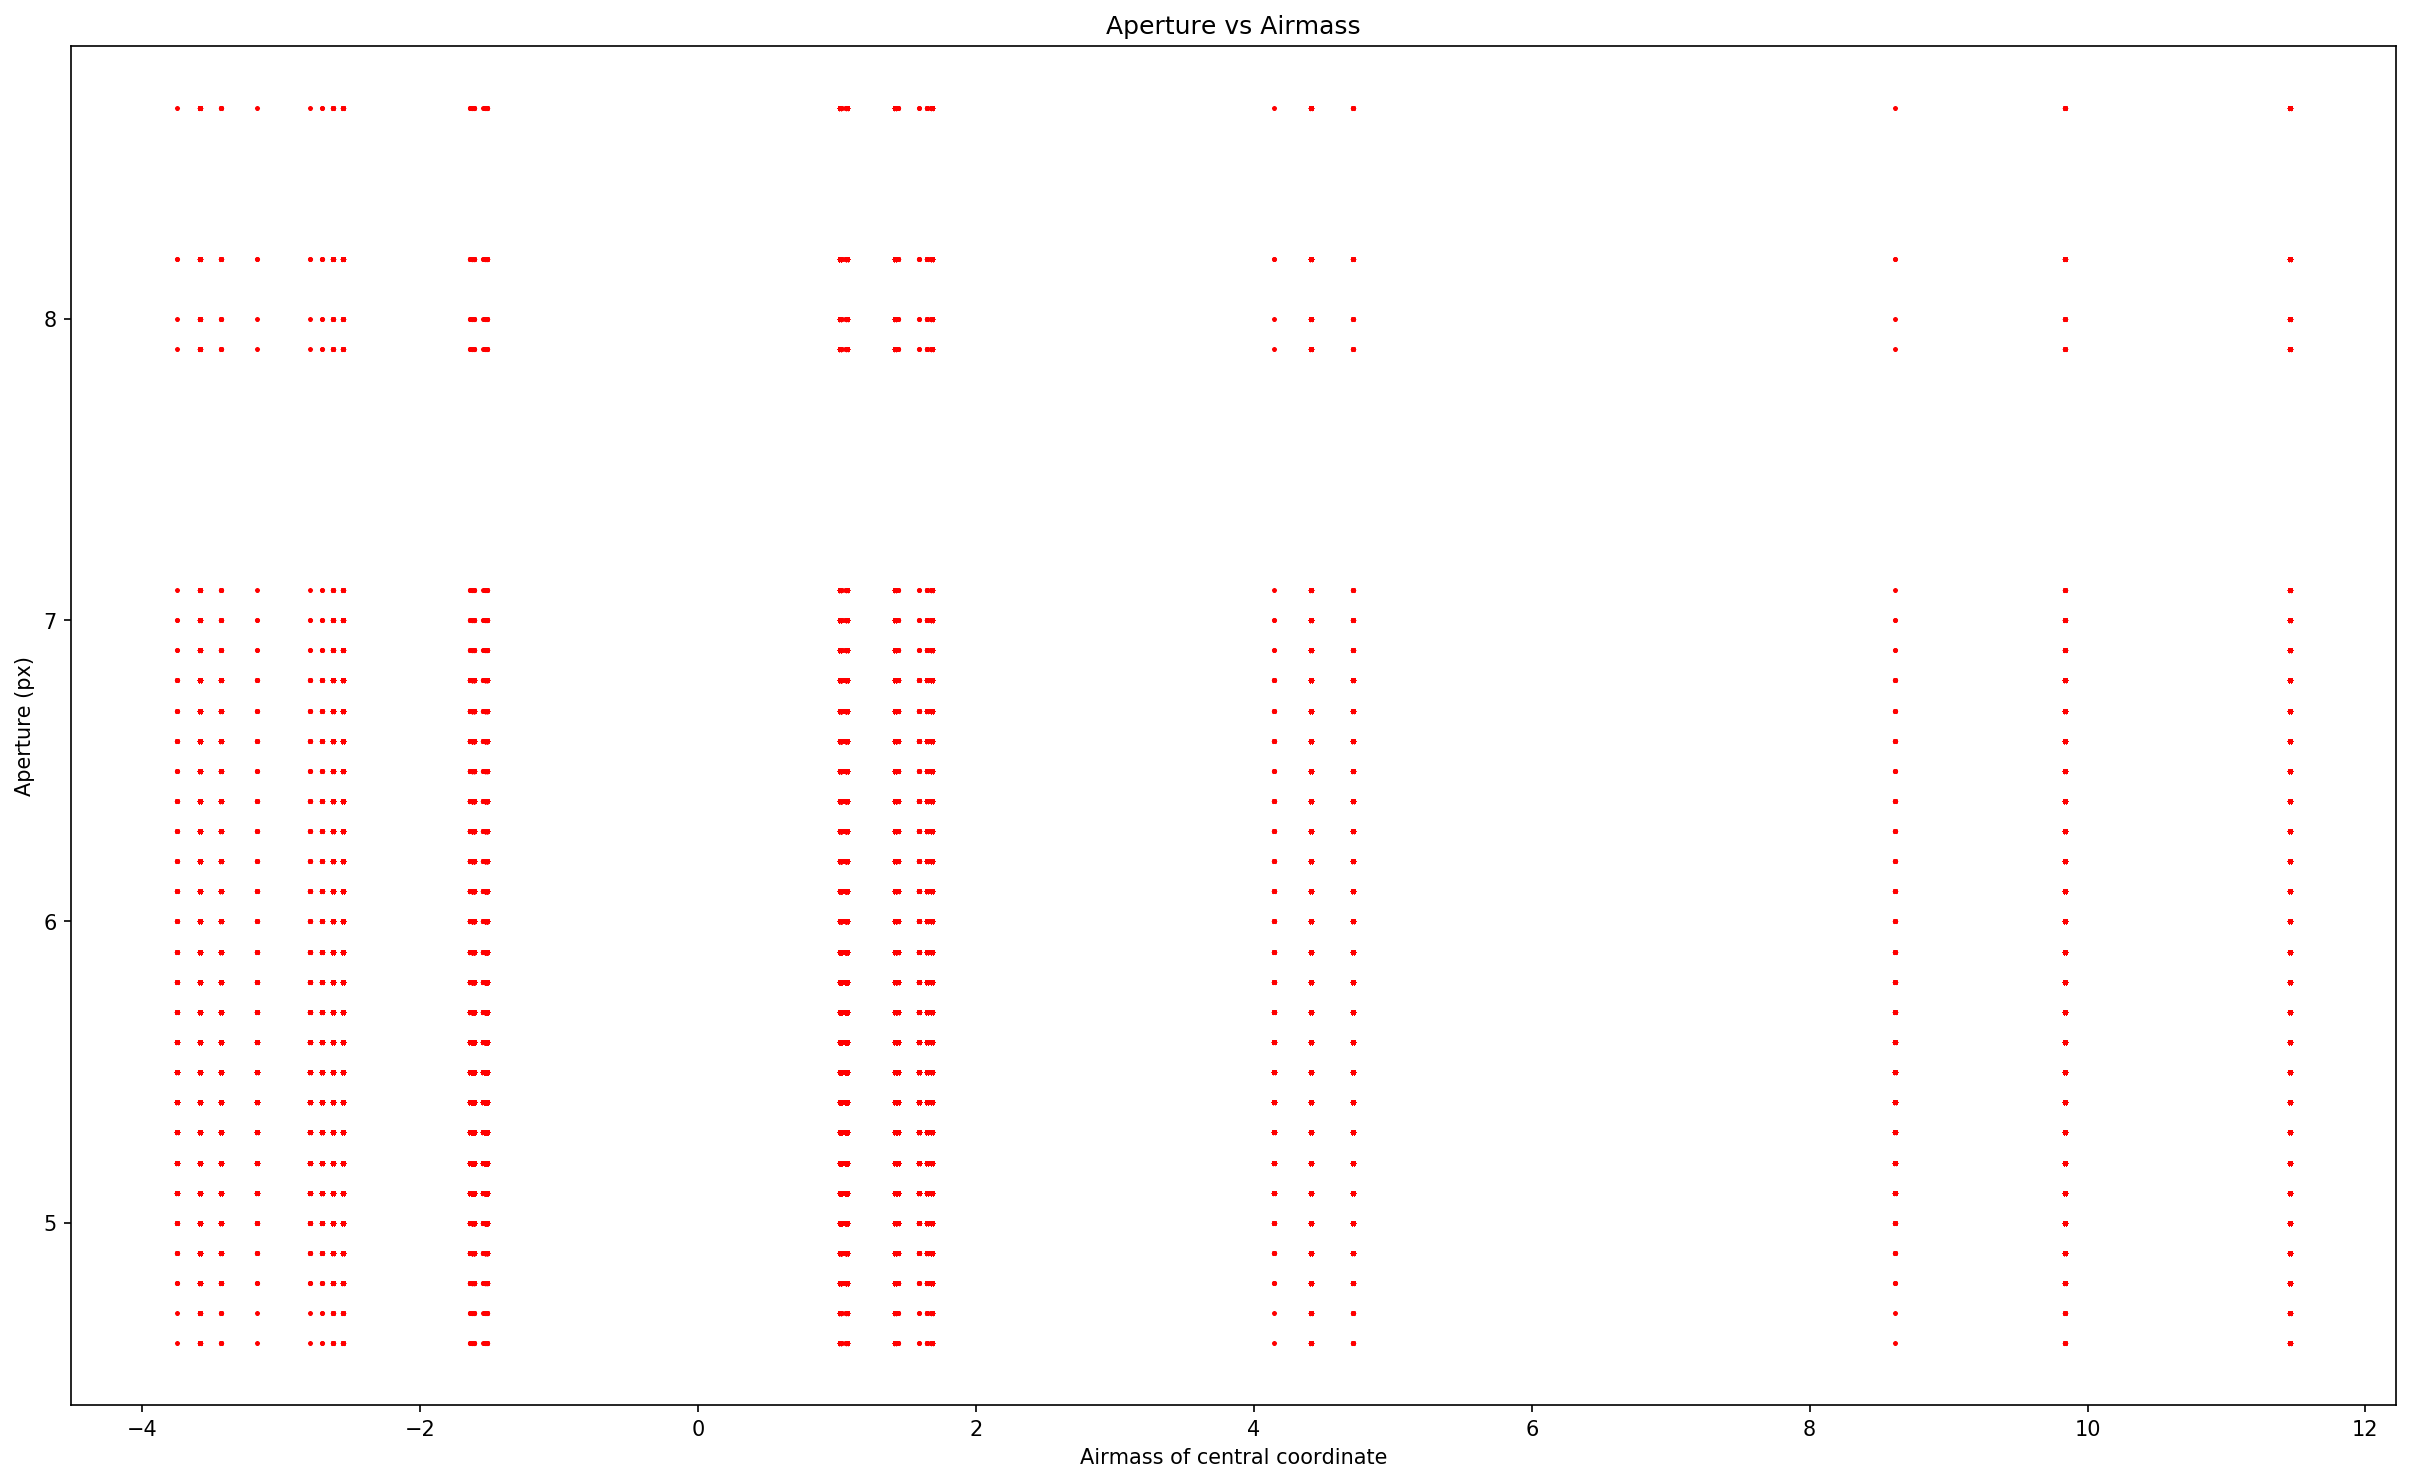

In [8]:
import do_aavso_report
import toml
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy import units as u
from tqdm import tqdm

settings = toml.load('../settings.txt')
sitelat=settings['sitelat']
sitelong=settings['sitelong']
sitealt=settings['sitealt']
observer=settings['observer']
earth_location = EarthLocation(lat=sitelat, lon=sitelong, height=sitealt * u.m)

xair = []
#central_coord = SkyCoord.from_pixel(700,700)
central_coord = SkyCoord(40,10, unit='deg')
for entry, yy in tqdm(zip(x, y), total=len(x), desc="Calculating airmass", unit="JD"):
    result = do_aavso_report.calculate_airmass(central_coord, earth_location, y).value
    xair.append(result)

fig = plt.figure(figsize=(20, 12), dpi=150)
ax = plt.subplot(111)
ax.plot(xair,y, '*r', markersize=2)
ax.tick_params(axis='x', which='minor', bottom=False)
ax.set_title('Aperture vs Airmass')
plt.xlabel('Airmass of central coordinate')
plt.ylabel('Aperture (px)')
